In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import requests 

In [3]:
import datetime

In [4]:
import os 
os.chdir('E://bond-dex/bond-amm-research')

In [5]:
datetime.datetime(2022, 1, 1).timestamp()

1640970000.0

## CIR Model

In [6]:
class Rate(): 
    
    def __init__(self, T, N, r0, a, b, sigma): 
        self.T = T
        self.N = N 
        self.r0 = r0 
        self.a = a 
        self.b = b 
        self.sigma = sigma 
        self.dt = T / N
        
    def cir(self): 
        
        out = np.zeros(self.N)
        
        out[0] = r0 
        
        for i in range(self.N - 1):
            dr_i = self.a * (self.b - out[i]) * self.dt + self.sigma * np.sqrt(out[i]) * np.random.normal() * np.sqrt(self.dt)
            out[i + 1] = out[i] + dr_i
        
        return out

In [7]:
def calculate_x(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r - r_min) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau)


def calculate_y(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r_max - r) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau - r * tau)

In [24]:
T = 1/365
N = int(T * 365 * 24 * 60)

sigma=0.1
a=5
b=0.05

r0 = 0.05

x0 = 0.53

In [25]:
rate = Rate(T=T, N=N, r0=r0, a=a, b=b, sigma=sigma)

r = rate.cir()

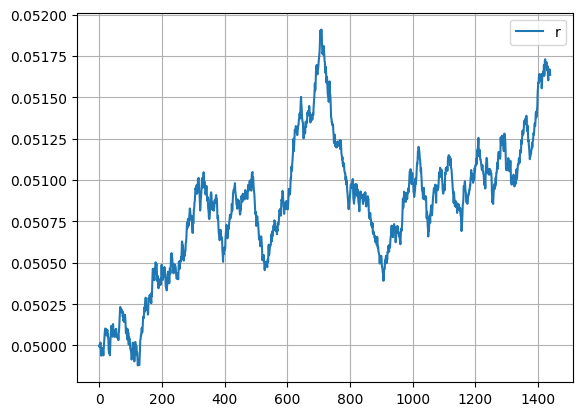

In [26]:
plt.plot(r, label='r')

plt.grid()

plt.legend()

In [27]:
from tqdm import tqdm

In [51]:
negative_rates = []
positive_rates = []
flat_rates = []

for _ in tqdm(range(3000)): 
    while True: 
        rate = Rate(T=T, N=N, r0=r0, a=a, b=b, sigma=sigma)
        r = rate.cir()
        if (r.max() - r.min()) < 2 * abs(r[-1] - r[0]):
            break
    if abs(r[-1] - r[0]) < 0.0001: 
        flat_rates.append(r)
    elif r[-1] > r[0]: 
        positive_rates.append(r)
    else: 
        negative_rates.append(r)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:30<00:00, 98.92it/s]


In [52]:
negative_rates = np.array(negative_rates)
positive_rates = np.array(positive_rates)
flat_rates = np.array(flat_rates)

In [53]:
negative_rates.shape, positive_rates.shape, flat_rates.shape

((1496, 1440), (1504, 1440), (0,))

## Simulate rate 

In [54]:
def scale_rate(a, b, rate):
    r0 = rate[0]
    r1 = rate[-1]
    new_rate = (rate - r0)/(r1-r0) * (b - a) + a
    return new_rate

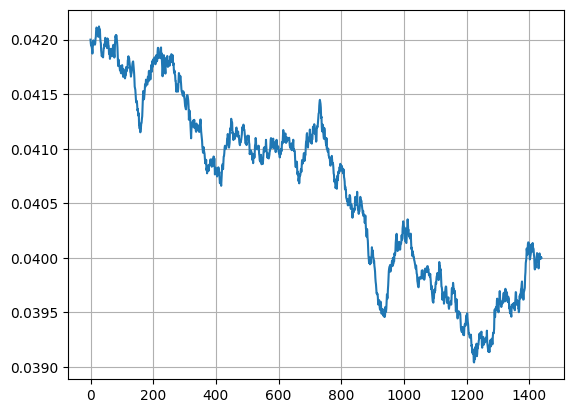

In [55]:
plt.plot(scale_rate(0.042, 0.04, negative_rates[0]))
plt.grid()

## AAVE ETH stable rate

In [16]:
from_date = datetime.datetime(2022, 1, 1).timestamp()
to_date = datetime.datetime(2023, 9, 1).timestamp()

url = f'https://aave-api-v2.aave.com/data/rates-history?reserveId=0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc20xB53C1a33016B2DC2fF3653530bfF1848a515c8c5&from={from_date}&to={to_date}&resolutionInHours=24'

In [17]:
response = requests.get(url)

In [18]:
df = pd.DataFrame(response.json())

In [19]:
df['trans_date'] = df.x.apply(lambda x: datetime.datetime(x['year'], x['month'] + 1, x['date']))

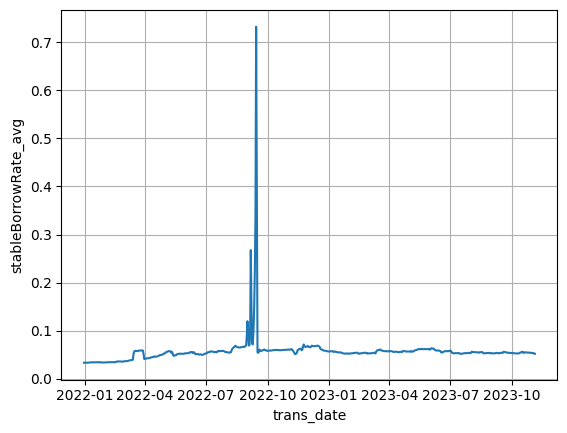

In [20]:
sns.lineplot(data=df, x='trans_date', y='stableBorrowRate_avg')

plt.grid()

In [17]:
df = pd.read_csv('data/input/interest_rate/avve_eth_stable_rate.csv')

## Fit rate to data

In [56]:
daily_r = df.query('trans_date >= "2022-10-01"').stableBorrowRate_avg.tolist()

In [57]:
minute_r = []

for i in range(len(daily_r) - 1): 
    r1 = daily_r[i]
    r2 = daily_r[i+1]
    
    if r2 > r1: 
        random_rate = positive_rates[np.random.choice(len(positive_rates), size=1)[0]]
    else: 
        random_rate = negative_rates[np.random.choice(len(negative_rates), size=1)[0]]
        
    new_r = scale_rate(r1, r2, random_rate)
    
    if min(new_r) < 0:
        print(i)
        print(new_r)
    
    minute_r.extend(new_r[1:])

In [58]:
daily_r[248], daily_r[249]

(0.062634009870981, 0.0611061163317526)

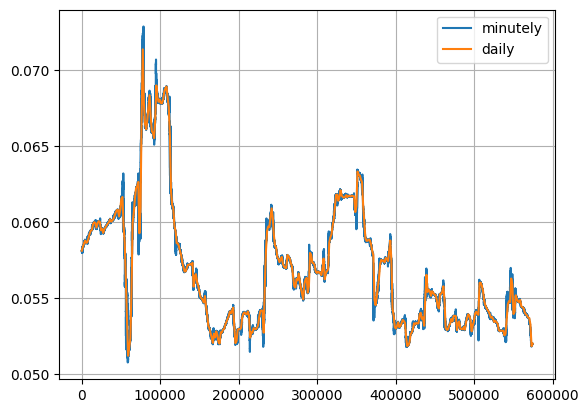

In [59]:
fig, ax = plt.subplots()

ax.plot(minute_r, label='minutely')

ax.plot(np.arange(len(daily_r)) * 24 * 60,daily_r, label='daily')

plt.legend()

plt.grid()

In [60]:
rate_df = pd.DataFrame({'timestamp': range(len(minute_r)), 'rate': minute_r})

In [61]:
rate_df.to_csv('data/input/interest_rate/eth_simulated_rate1.csv', index=False)